In [4]:
import jax
import jax.numpy as jnp
import numpy as np

In [5]:
words = open('names.txt').read().splitlines()
len(words)

1356048

In [6]:
J = np.zeros((27,27), dtype=np.int32)
# J = jnp.array(J)
J.shape

(27, 27)

In [7]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0


In [8]:
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        J[ix1, ix2] += 1

In [ ]:
itos = {i:s for s,i in stoi.items()}

(np.float64(-0.5), np.float64(26.5), np.float64(26.5), np.float64(-0.5))

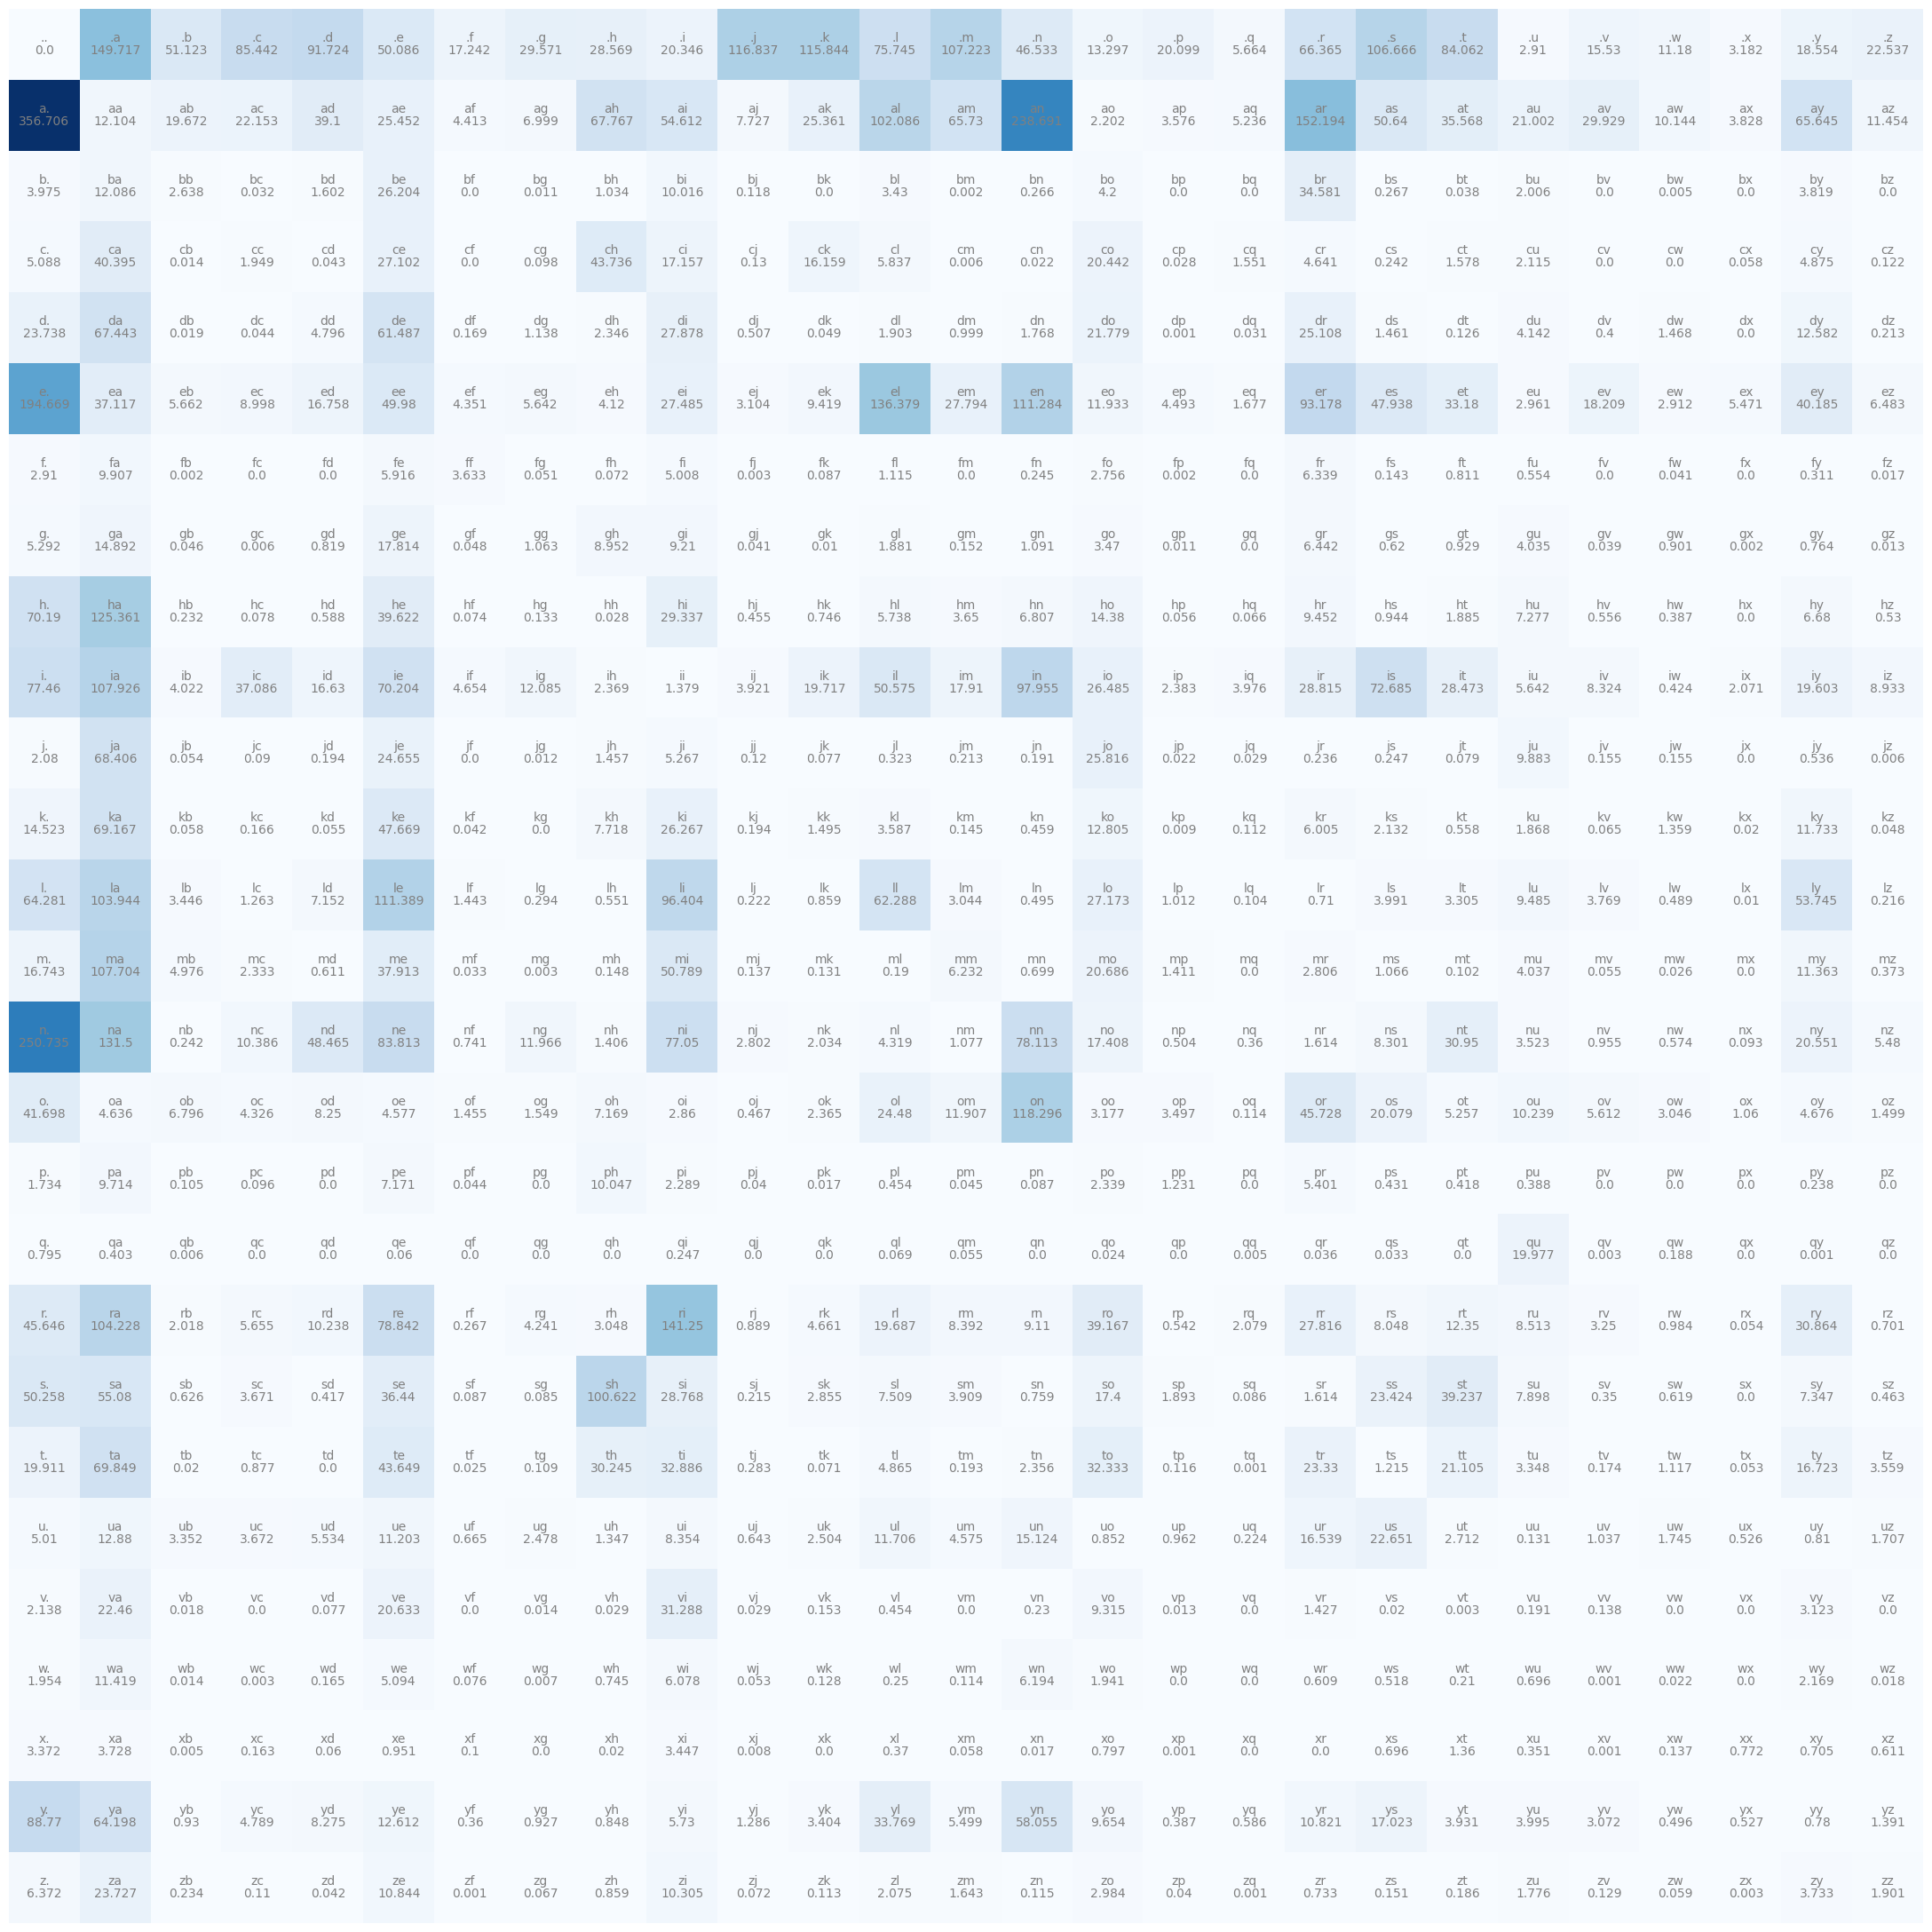

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(28,28))
plt.imshow(J, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j,i,chstr,ha="center", va="bottom", color='gray')
        repeatTimes = round(J[i,j].item()/1000, 3)
        plt.text(j,i,repeatTimes, ha="center", va="top", color='gray')
plt.axis('off')

In [ ]:
p = J[0].astype(np.float32) / J[0].sum().astype(np.float32)
p

array([0.        , 0.11040686, 0.03769999, 0.06300809, 0.06764068,
       0.03693527, 0.01271489, 0.02180675, 0.02106784, 0.01500389,
       0.08615993, 0.08542766, 0.05585717, 0.07907021, 0.03431516,
       0.0098057 , 0.01482175, 0.00417684, 0.04894001, 0.07865946,
       0.06199043, 0.00214594, 0.0114524 , 0.00824455, 0.00234652,
       0.01368241, 0.01661962], dtype=float32)

In [ ]:
# numpy use generator object in multinomial and generate 20 samples with probability r3Norm
g = np.random.default_rng(2147483647)
val = g.multinomial(1, p, 10).argmax(axis=1)
# Get index of the maximum value in each row
val
li = [itos[i] for i in val.tolist()]
li

['h', 'k', 'd', 'a', 's', 'd', 'r', 'a', 'p', 't']

In [ ]:
# Count the number of times each character appears
count = [0] * 27
for i in range(10):
    count[val[i]] += 1

# Print the number of times each character appears
for i in range(27):
    print(itos[i], count[i])

. 0
a 2
b 0
c 0
d 2
e 0
f 0
g 0
h 1
i 0
j 0
k 1
l 0
m 0
n 0
o 0
p 1
q 0
r 1
s 1
t 1
u 0
v 0
w 0
x 0
y 0
z 0


In [ ]:
rowSum = J.sum(axis=1, keepdims=True).astype(np.float32)
J = J.astype(np.float32)
J /= rowSum

In [ ]:
CopyJ = J.copy()
# jaxJ = jnp.array(CopyJ)

In [ ]:
g = np.random.default_rng(2147483647)

for i in range(10):
    ix = 0
    while True:
        ix = g.multinomial(1, J[ix], 1).argmax(axis=1).item()
        print(itos[ix], end='')
        if ix == 0:
            break
    print()

h.
ja.
a.
shmielieurishetasmanady.
mylishtoleva.
s.
tian.
she.
zoxya.
lica.


In [ ]:
log_likelihood = 0.0
n = 0
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = J[ix1, ix2]
        logprob  = np.log(prob)
        log_likelihood += logprob
        n += 1
        # print(f'{ch1}->{ch2} : {logprob:.1f}')
print(f'log likelihood: {log_likelihood:.1f}')
print(f'negative log likelihood: {-log_likelihood:.1f}')
print(f'avergae negative log likelihood: {-log_likelihood/n:.1f}') # Lower the better

log likelihood: -23712614.0
negative log likelihood: 23712614.0
avergae negative log likelihood: 2.4


In [ ]:
# Training Set

xs, ys = [], []

for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = np.array(xs, dtype=np.int32)
ys = np.array(ys, dtype=np.int32)

xs.shape, ys.shape

((6,), (6,))

In [ ]:
def loss_fn(W, X, Y):
    logits = X @ W
    # Softmax
    counts = jnp.exp(logits)
    probs = counts / counts.sum(axis=1, keepdims=True)
    loss = -jnp.log(probs[np.arange(6), Y]).mean().item()
    print("Fwd pass Loss: ", loss)
    return loss

def train(W, X, Y, lr=0.1):
    gradFn = jax.grad(loss_fn, argnums=(0))
    gW = gradFn(W, X, Y)
    W -= lr * gW
    return W



In [ ]:
# Weights
seed = 43
rng = jax.random.PRNGKey(seed)

# 1st Layer: 27x27 f32

W = jax.random.normal(rng, (27, 27)).astype(np.float32)

# OneHotEncoding
xEnc = jax.nn.one_hot(xs, 27).astype(np.float32)
yEnc = jax.nn.one_hot(ys, 27).astype(np.float32)


for i in range(100):
    W = train(W, xEnc, ys)
    print(f'Iteration {i}: Loss: {loss_fn(W, xEnc, ys):.1f}')

Fwd pass Loss:  3.335744619369507
Fwd pass Loss:  3.335744619369507
Iteration 0: Loss: 3.3
Fwd pass Loss:  3.335744619369507
Fwd pass Loss:  3.335744619369507
Iteration 1: Loss: 3.3
Fwd pass Loss:  3.335744619369507
Fwd pass Loss:  3.335744619369507
Iteration 2: Loss: 3.3
Fwd pass Loss:  3.335744619369507
Fwd pass Loss:  3.335744619369507
Iteration 3: Loss: 3.3
Fwd pass Loss:  3.335744619369507
Fwd pass Loss:  3.335744619369507
Iteration 4: Loss: 3.3
Fwd pass Loss:  3.335744619369507
Fwd pass Loss:  3.335744619369507
Iteration 5: Loss: 3.3
Fwd pass Loss:  3.335744619369507
Fwd pass Loss:  3.335744619369507
Iteration 6: Loss: 3.3
Fwd pass Loss:  3.335744619369507
Fwd pass Loss:  3.335744619369507
Iteration 7: Loss: 3.3
Fwd pass Loss:  3.335744619369507
Fwd pass Loss:  3.335744619369507
Iteration 8: Loss: 3.3
Fwd pass Loss:  3.335744619369507
Fwd pass Loss:  3.335744619369507
Iteration 9: Loss: 3.3
Fwd pass Loss:  3.335744619369507
Fwd pass Loss:  3.335744619369507
Iteration 10: Loss: 3.